## Compare levenshtein distance of evotuning sequence members to wild-type GFP or beta-lactamase.

## Additionally create the evotuning sequence sets needed for the ablation experiment presented in Supp Fig. 9.

This notebook produces the plots in Supp Fig 7.

In [1]:
import os
import sys
import pickle
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns

from sklearn.linear_model import LassoLarsCV


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils


%reload_ext autoreload
%autoreload 2

In [3]:
ET_SEQ_DIRS = [
    os.path.join(data_io_utils.S3_DATA_ROOT, 'evotuning_checkpoints/gfp/seqs_1'),
    os.path.join(data_io_utils.S3_DATA_ROOT, 'evotuning_checkpoints/gfp/seqs_2'),
    os.path.join(data_io_utils.S3_DATA_ROOT, 'evotuning_checkpoints/beta_lactamase/seqs')
]

for etd in ET_SEQ_DIRS:
    data_io_utils.sync_s3_path_to_local(etd)

## Load up the sequences

In [4]:
def read_simple_seq_file(seq_file):
    with open(seq_file) as f:
        rseqs = f.read().splitlines()
        
    return rseqs

In [5]:
gfp_seqs_1 = (
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/gfp/seqs_1/wide_jackhmmer_3_train.txt')) + 
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/gfp/seqs_1/wide_jackhmmer_3_in_val.txt')) + 
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/gfp/seqs_1/wide_jackhmmer_3_out_val.txt'))
)

print(len(gfp_seqs_1))

32225


In [6]:
# Note that Grigory & Ethan had an AWS storage issue for which they don't 
# know the original split into train, in_val, and out_val
gfp_seqs_2 = read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/gfp/seqs_2/GFP2_final_full.txt')) 

print(len(gfp_seqs_2))

79482


In [7]:
blac_seqs = (
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/beta_lactamase/seqs/train_betalac2.txt')) + 
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/beta_lactamase/seqs/in_val_betalac2.txt')) + 
    read_simple_seq_file(os.path.join(data_io_utils.S3_DATA_ROOT, 
        'evotuning_checkpoints/beta_lactamase/seqs/out_val_betalac2.txt'))
)

print(len(blac_seqs))

76735


## Create histogram of levenshtein distances of ET set members to wildtype.

In [8]:
FRAC_SIMILARITY_THRESHOLD = 0.72

In [9]:
with open('../../data/uniref50_len_bin.p', 'rb') as f:
    uni_len_dict = pickle.load(f)

In [10]:
def generate_length_matched_random_seq_set(seqs, uni_len_dict):
    len_keys = np.array(list(uni_len_dict.keys()))

    num_same = 0
    rseqs = []
    for seq in seqs:
        if len(seq) not in uni_len_dict:
            closest_len = len_keys[np.argmin(np.abs(len_keys - len(seq)))]
            print(len(seq), closest_len)
            use_len = closest_len
        else:
            use_len = len(seq)
            
        sl = uni_len_dict[len(seq)]
        rseqs.append(random.choice(sl))
        
        if seq == rseqs[-1]:
            num_same += 1
    
    print('Number of sequences randomly drawn that are same as original:', num_same)
        
    return rseqs  

In [11]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plot_lev_dist_hist(ld_orig, ld_rand, wt_seq, nbins=100, similarity_thresh=FRAC_SIMILARITY_THRESHOLD):
        
    _, bin_edges = np.histogram(ld_orig, bins=nbins)
    
    nmut_thresh = int(len(wt_seq)*similarity_thresh)
    
    plt.hist(ld_orig, bins=bin_edges, color='b', alpha=0.7, rwidth=1)
    plt.hist(ld_rand, bins=bin_edges, color='r', alpha=0.3, rwidth=1)
    plt.legend(['Evotuning seqs', 'Random seqs (length-matched)'], bbox_to_anchor=(1.05, 1))
    
    plt.axvline(nmut_thresh, color='grey')
    
    
    def fnum(ld, s=1):
        if s == 1:
            n = np.sum(ld < nmut_thresh)
        else:
            n = np.sum(ld >= nmut_thresh)
        return (str(int(n)) + ' seqs (%.1f%%)' % (100*n/len(ld))).replace('(100.0', ' (100')
    
    # Sequence nums left of the line.
    hleft = 0.35
    hd = 0
    
    hright = 0.9
    vheight = 0.5
    vd = 0.08
    
    if wt_seq[:4] == 'MSIQ':
        hd = 0.2
        
    plt.text(hleft, vheight, fnum(ld_orig), horizontalalignment='right',
            verticalalignment='center', transform=plt.gca().transAxes, color='b')
    plt.text(hleft, vheight-vd, fnum(ld_rand), horizontalalignment='right',
            verticalalignment='center', transform=plt.gca().transAxes, color='r')
    
    plt.text(hright + hd, vheight, fnum(ld_orig, s=-1), horizontalalignment='right',
            verticalalignment='center', transform=plt.gca().transAxes, color='b')
    plt.text(hright + hd, vheight-vd, fnum(ld_rand, s=-1), horizontalalignment='right',
            verticalalignment='center', transform=plt.gca().transAxes, color='r')
    
    
    v = plt.axis()
    current_ticks = [-100, 0, 100, 200, 300, 400, 500, 600] #list(np.array(plt.xticks()[0]).astype(int))
    plt.xticks(current_ticks + [len(wt_seq)])
    plt.gca().set_xticklabels(current_ticks + [''])
    plt.axis([-30, 430] + list(v[2:]))
    
def plot_lev_dist_cum_dist_plot(ld_orig, ld_rand, wt_seq):
    ld_x = np.linspace(0, len(wt_seq)+1, 100)

    ldo = copy.deepcopy(ld_orig)
    ldr = copy.deepcopy(ld_rand)
    ldo = np.minimum(ldo, len(wt_seq))
    ldr = np.minimum(ldr, len(wt_seq))

    cum_frac_orig = np.array([np.sum(ldo <= x)/len(ldo) for x in ld_x])
    cum_frac_rand = np.array([np.sum(ldr <= x)/len(ldr) for x in ld_x])
    
    plt.plot(100*ld_x/len(wt_seq), cum_frac_orig, '-b', linewidth=3, alpha=0.7)
    plt.plot(100*ld_x/len(wt_seq), cum_frac_rand, '-r', linewidth=3, alpha=0.5)
    plt.xlabel('Percent dissimilarity to wild-type')
    plt.ylabel('Fraction of sequences')

    
def generate_lev_dist_summary_plot(wt_seq, et_seqs, title=None):
    
    rseqs = generate_length_matched_random_seq_set(et_seqs, uni_len_dict)
    
    ld_orig = utils.levenshtein_distance_matrix([wt_seq], et_seqs).reshape(-1)
    ld_rand = utils.levenshtein_distance_matrix([wt_seq], rseqs).reshape(-1)
    
    fig1 = plt.figure(figsize=(8,4))
    plot_lev_dist_hist(ld_orig, ld_rand, wt_seq)
    plt.xlabel('Edit distance to wild-type')
    plt.ylabel('Num. sequences')
    plt.title(title)
    plt.show()
    
    fig2 = plt.figure()
    plot_lev_dist_cum_dist_plot(ld_orig, ld_rand, wt_seq)
    plt.show()
    
    return fig1, fig2

Number of sequences randomly drawn that are same as original: 0


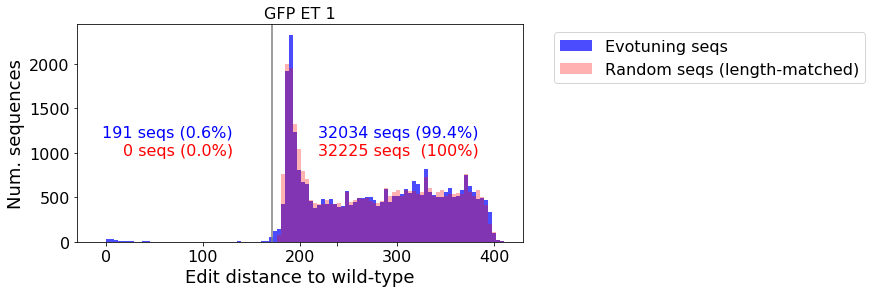

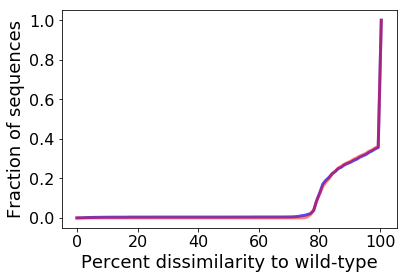

Number of sequences randomly drawn that are same as original: 0


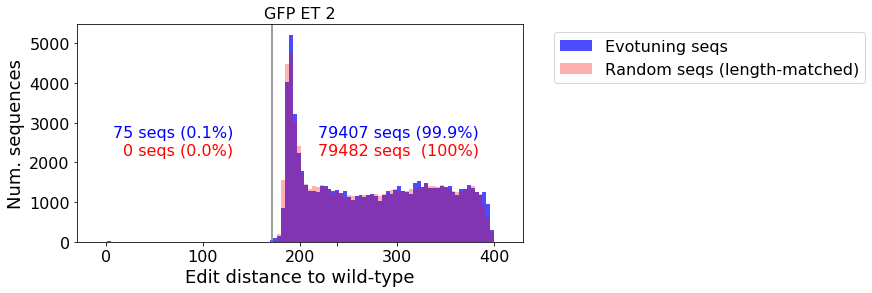

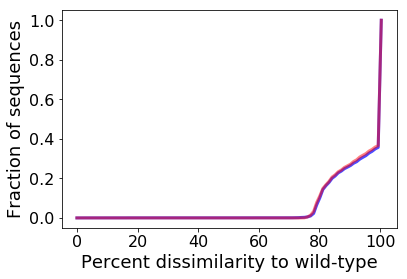

Number of sequences randomly drawn that are same as original: 0


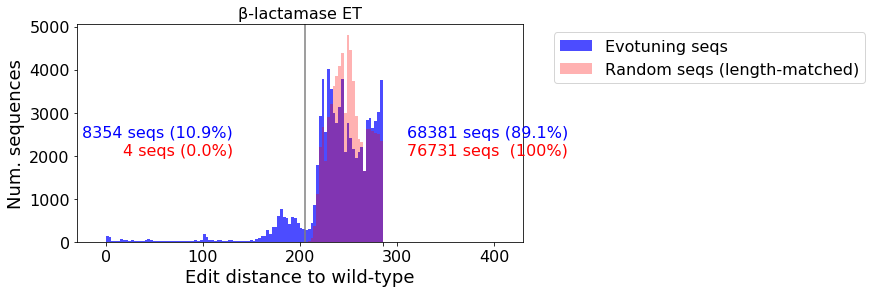

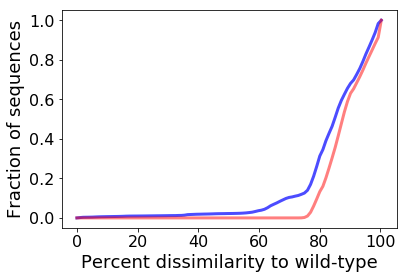

In [12]:
np.random.seed(42)
random.seed(42)

fig1, fig2 = generate_lev_dist_summary_plot(constants.AVGFP_AA_SEQ, gfp_seqs_1, title='GFP ET 1')
plot_style_utils.save_for_pub(fig=fig1, path='figures/GFP_ET1_evotuning_lev_dist_hist')
plot_style_utils.save_for_pub(fig=fig2, path='figures/GFP_ET1_evotuning_lev_dist_cumdist')

fig1, fig2 = generate_lev_dist_summary_plot(constants.AVGFP_AA_SEQ, gfp_seqs_2, title='GFP ET 2')
plot_style_utils.save_for_pub(fig=fig1, path='figures/GFP_ET2_evotuning_lev_dist_hist')
plot_style_utils.save_for_pub(fig=fig2, path='figures/GFP_ET2_evotuning_lev_dist_cumdist')                              

fig1, fig2 = generate_lev_dist_summary_plot(constants.BETA_LAC_AA_SEQ, blac_seqs, title='β-lactamase ET')
plot_style_utils.save_for_pub(fig=fig1, path='figures/BLAC_ET_evotuning_lev_dist_hist')
plot_style_utils.save_for_pub(fig=fig2, path='figures/BLAC_ET_evotuning_lev_dist_cumdist')

Note on bounds for Levenshtein distance:

It is at least the difference of the sizes of the two strings.

It is at most the length of the longer string.

In [13]:
len_gfp_1 = np.array([len(s) for s in gfp_seqs_1])
len_gfp_2 = np.array([len(s) for s in gfp_seqs_2])
len_blac = np.array([len(s) for s in blac_seqs])

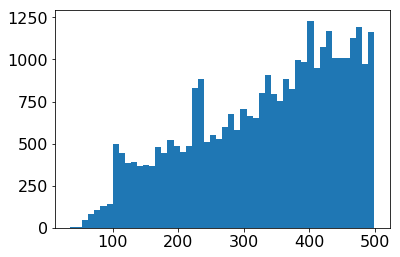

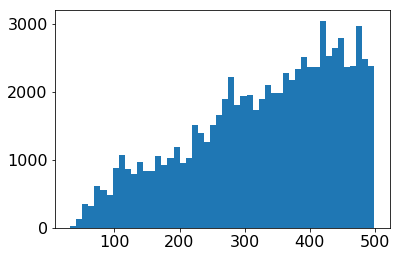

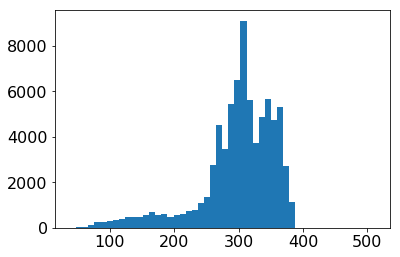

In [14]:
plt.hist(len_gfp_1, bins=50)
plt.show()

plt.hist(len_gfp_2, bins=50)
plt.show()

plt.hist(len_blac, bins=50)
plt.show()

## Create sequence sets 

In [15]:
def write_simple_seq_file(seqs, file):
    with open(file, 'w') as f:
        for s in seqs:
            f.write(s+'\n')
    

def write_et_seq_ablation_files(et_seqs, wt_seq, outfile_prefix, similarity_thresh=FRAC_SIMILARITY_THRESHOLD):
    ld_orig = utils.levenshtein_distance_matrix([wt_seq], et_seqs).reshape(-1)
    
    et_seq_arr = np.array(et_seqs)
    
    nmut_thresh = int(len(wt_seq)*similarity_thresh)
    close_seqs =list(et_seq_arr[ld_orig < nmut_thresh])
    far_seqs = list(et_seq_arr[ld_orig >= nmut_thresh]) 
    
    print(len(close_seqs), len(far_seqs))
    
    write_simple_seq_file(far_seqs, outfile_prefix + '_close_ablated.txt')
    write_simple_seq_file(close_seqs, outfile_prefix + '_far_ablated.txt')

In [16]:
write_et_seq_ablation_files(gfp_seqs_1, constants.AVGFP_AA_SEQ, 'et_ablation_seq_sets/GFP_ET1_seqs')
write_et_seq_ablation_files(gfp_seqs_2, constants.AVGFP_AA_SEQ, 'et_ablation_seq_sets/GFP_ET2_seqs')
write_et_seq_ablation_files(blac_seqs, constants.BETA_LAC_AA_SEQ, 'et_ablation_seq_sets/BLAC_ET_seqs')

191 32034
75 79407
8354 68381
